## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [1]:
from ipywidgets import interact, interactive, fixed
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import os.path
import cv2
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import sys
sys.path.append('../')
from utils import build_distort_p, load_distort_p, get_perspective_transform, thresh_filter, abs_sobel_thresh
from showcase import show_calibration_result, show_perspective_transform_result, show_color_threshold_result

In [3]:
DISTORT_P = 'distort.p'

is_show_calibration_result = False
is_show_perspective_transform_result = False
is_show_color_threshold_result = True

## First, I'll compute the camera calibration using chessboard images

In [4]:
if not os.path.isfile(DISTORT_P):
    build_distort_p(DISTORT_P)

mtx, dist = load_distort_p(DISTORT_P)

In [5]:
if is_show_calibration_result:
    show_calibration_result(mtx, dist)

## Decide the perspective tranform matrix

In [6]:
M = get_perspective_transform()

In [7]:
if is_show_perspective_transform_result:
    show_perspective_transform_result(mtx, dist, M)

## Use color transforms, gradients, etc., to create a thresholded binary image

1. Color space (Gray, HLS, YUV, HSV)
2. Sobel
3. Magnitude of the Gradient


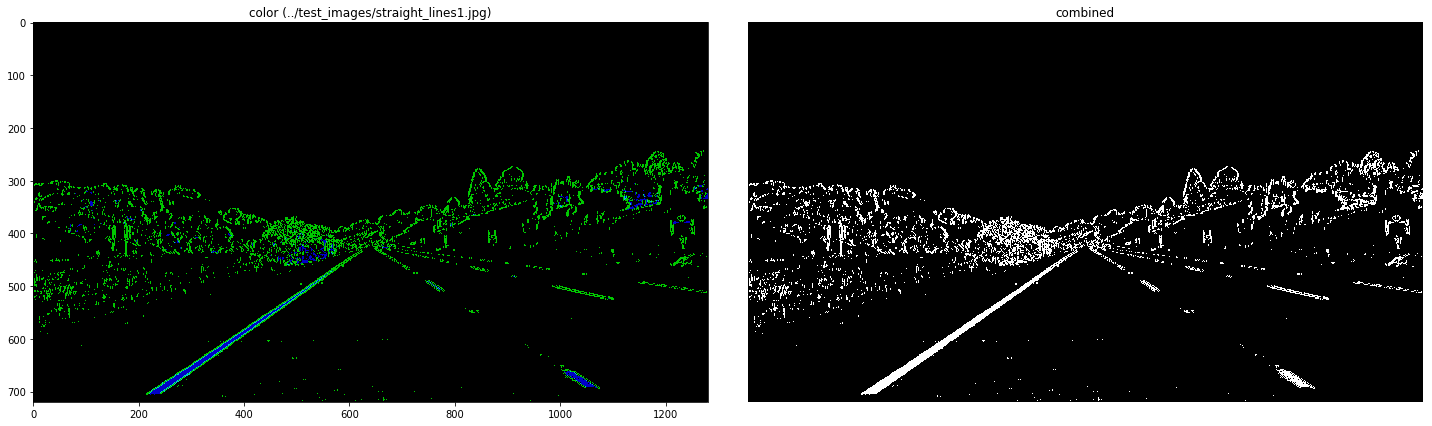

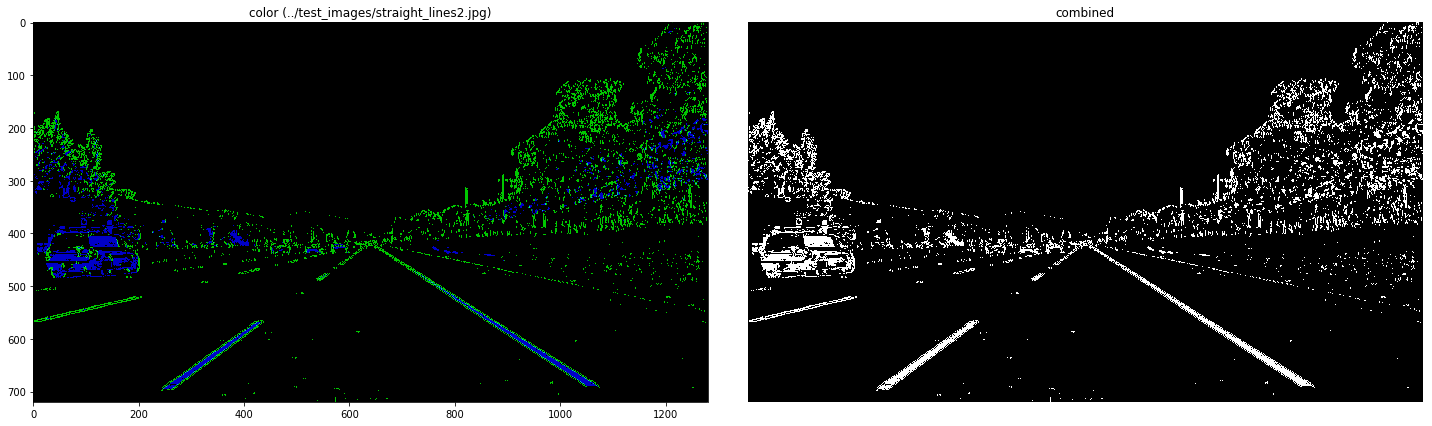

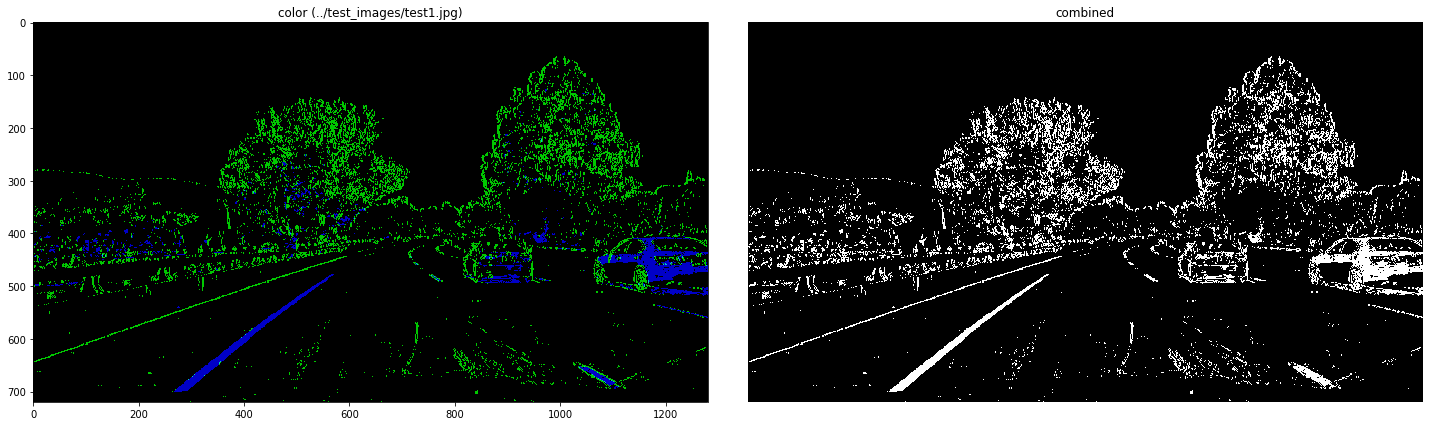

In [8]:
if is_show_color_threshold_result:
    show_color_threshold_result(mtx, dist, M)

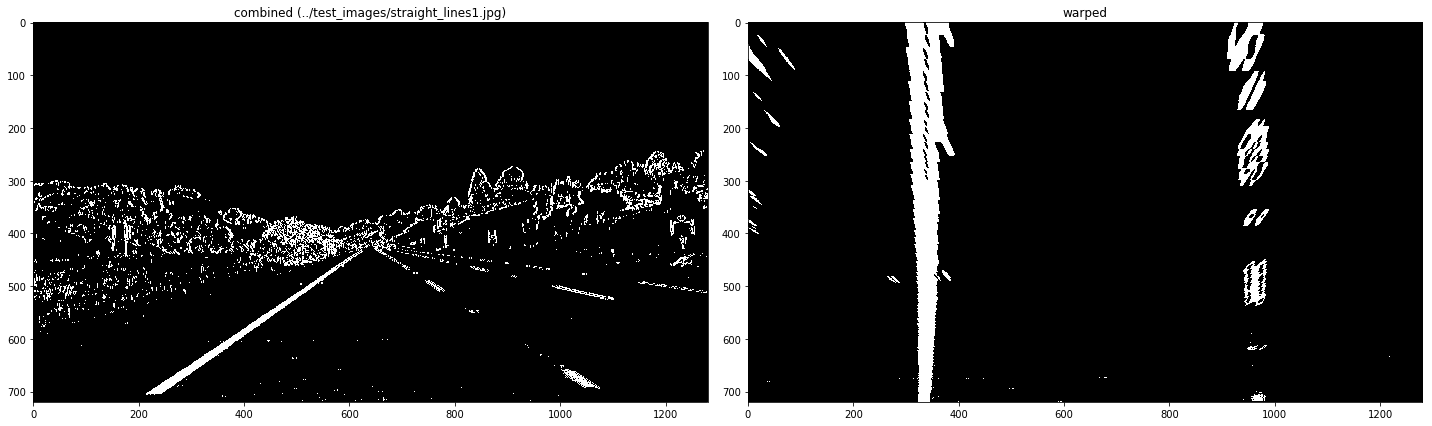

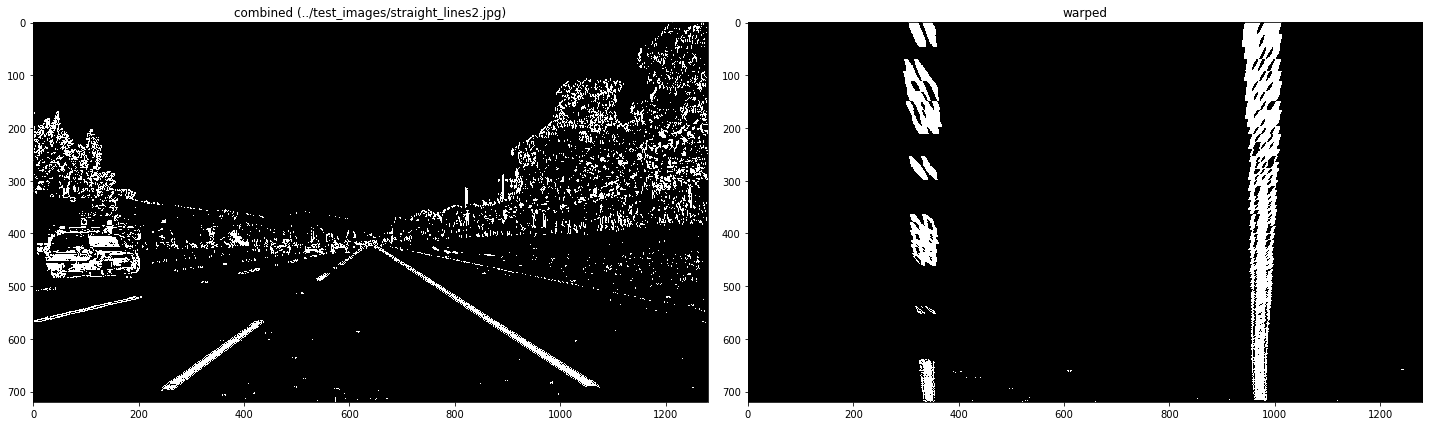

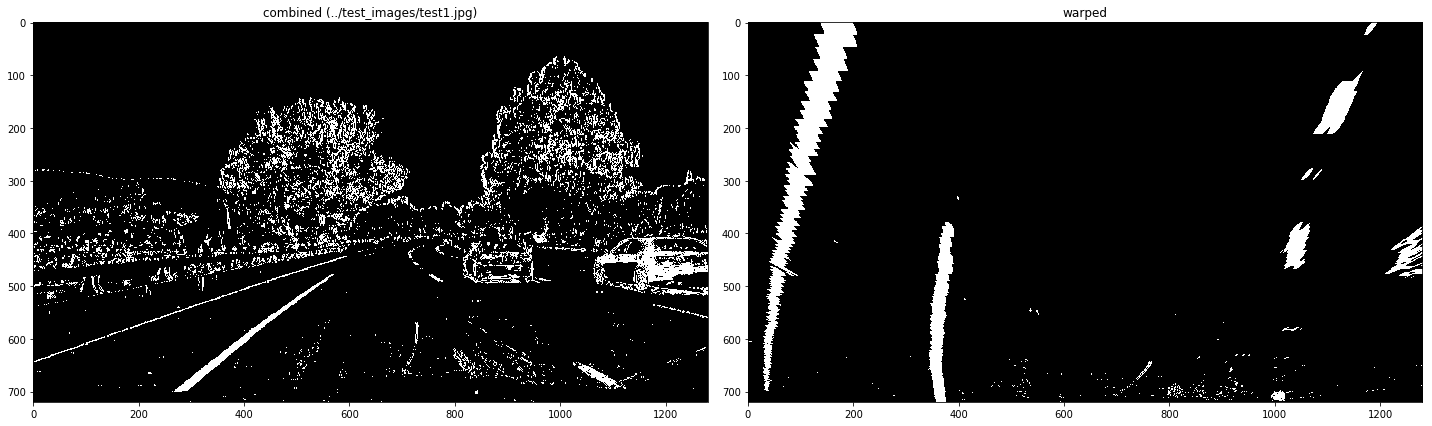

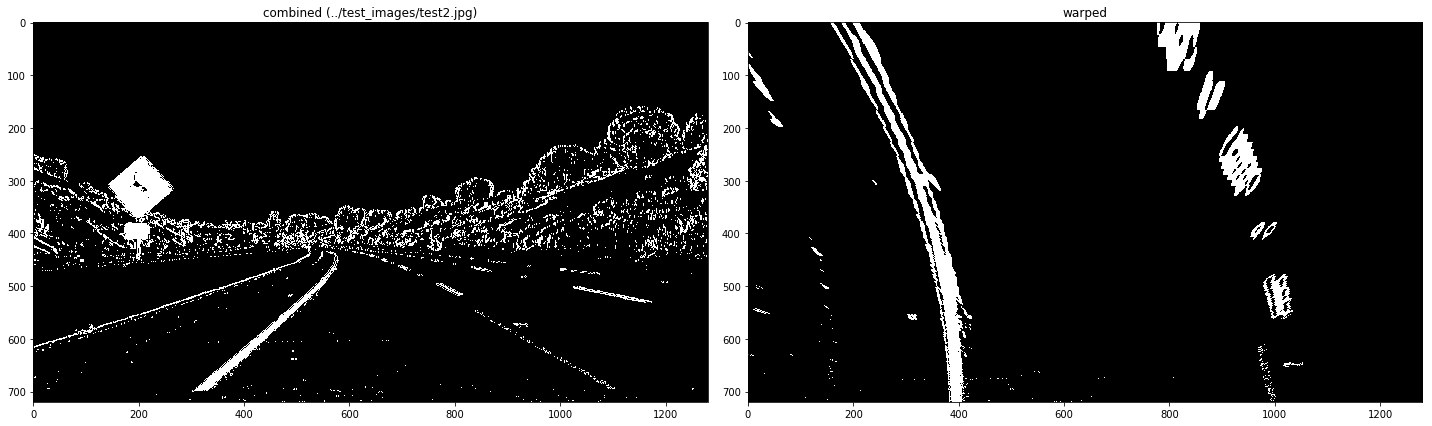

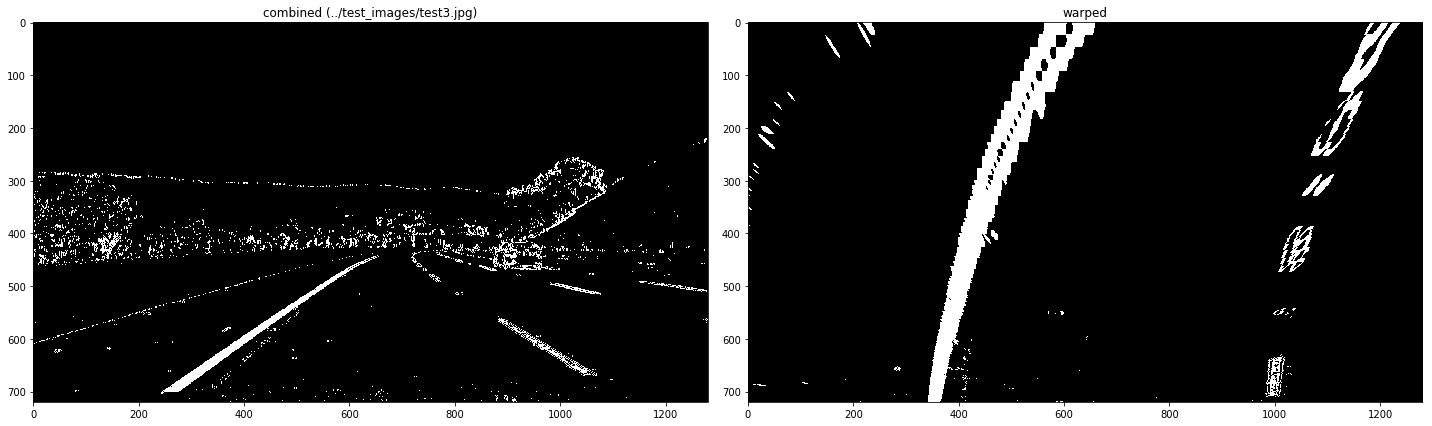

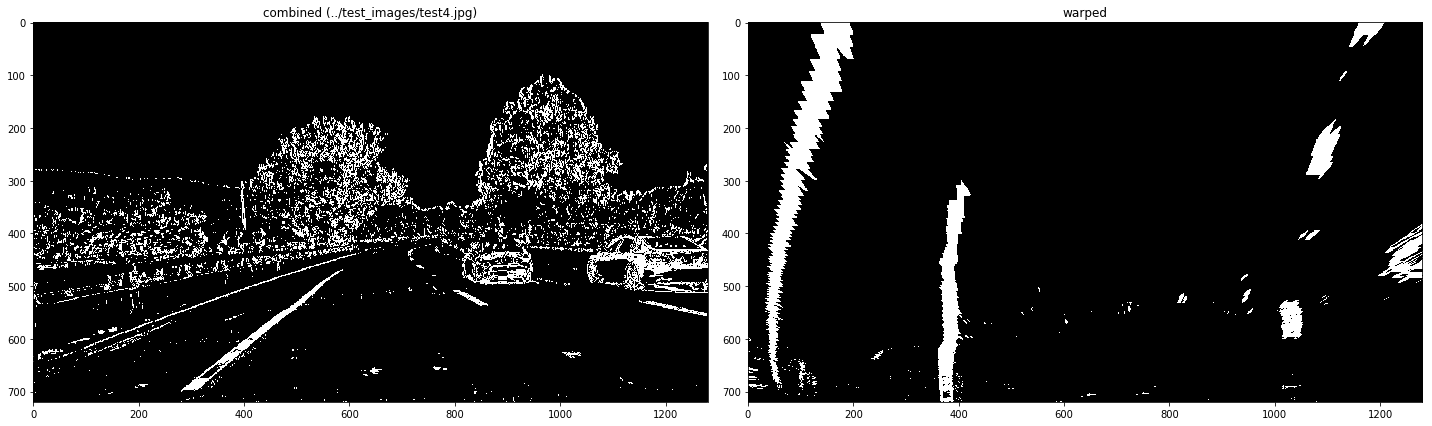

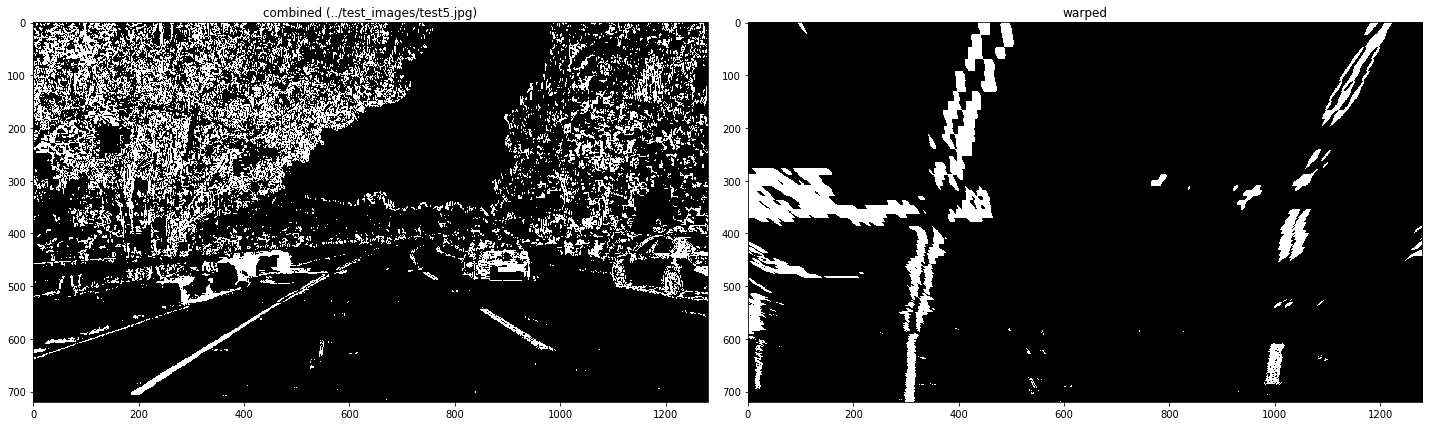

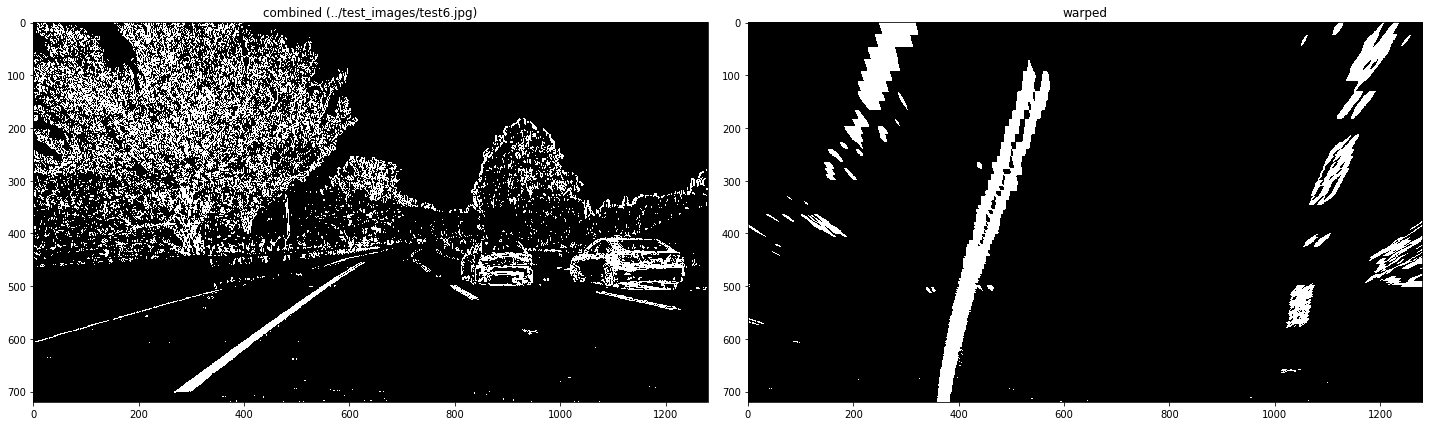

In [7]:
images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    s_binary = thresh_filter(s, (170, 255))

    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    sxbinary = abs_sobel_thresh(gray, 'x', 20, 100)

    #color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary*200, s_binary*200))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)

    fig = plt.figure(figsize=(20, 12))

    plt.subplot(121)
    plt.imshow(combined_binary, cmap='gray')
    plt.title('combined ('+fname+')')

    plt.subplot(122)
    plt.imshow(warped, cmap='gray')
    plt.title('warped')


#     plt.axis('off')
    fig.tight_layout()
    plt.show()

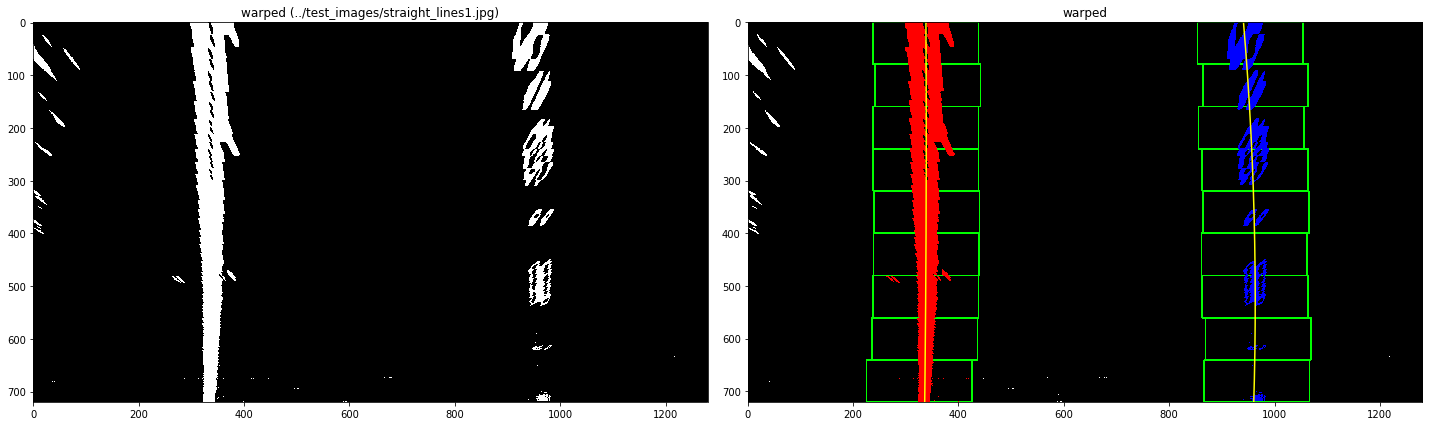

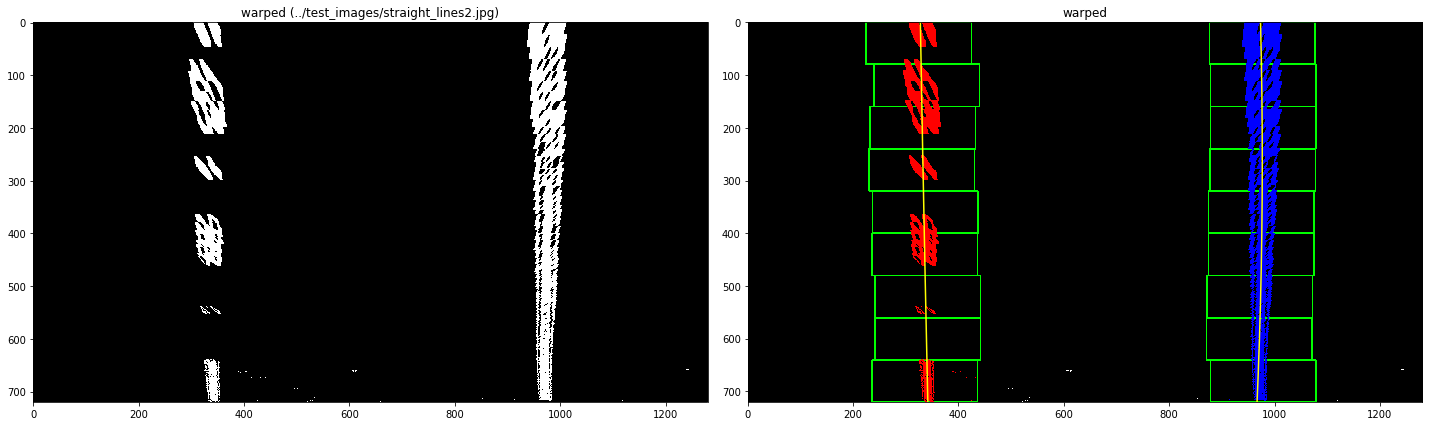

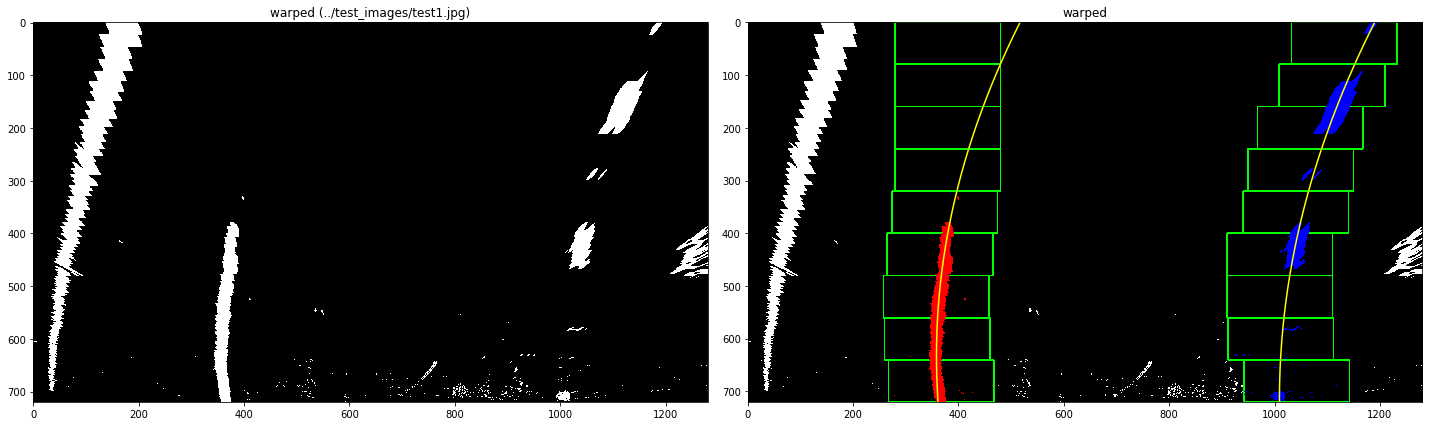

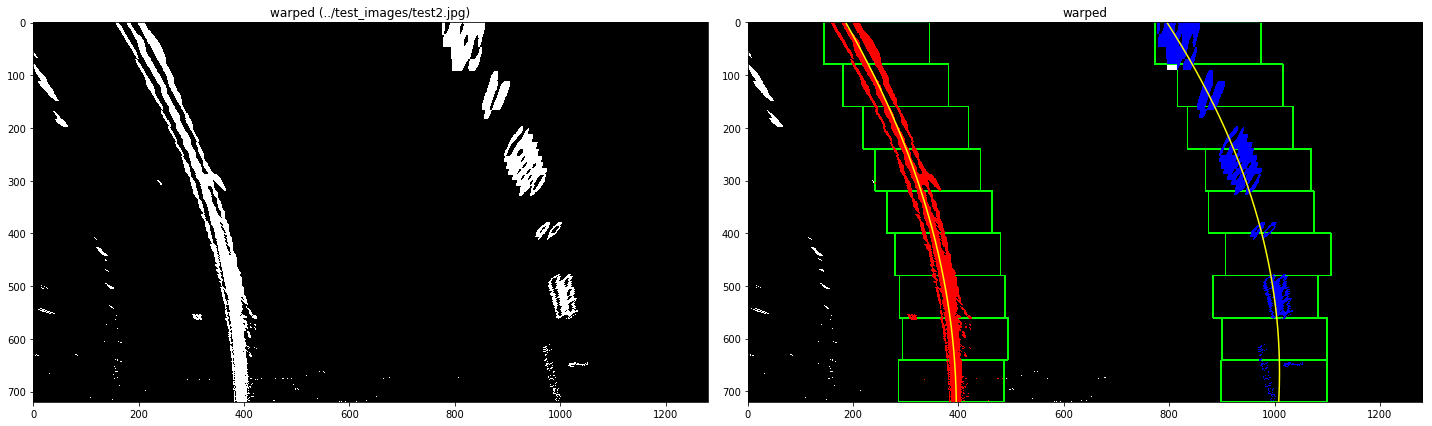

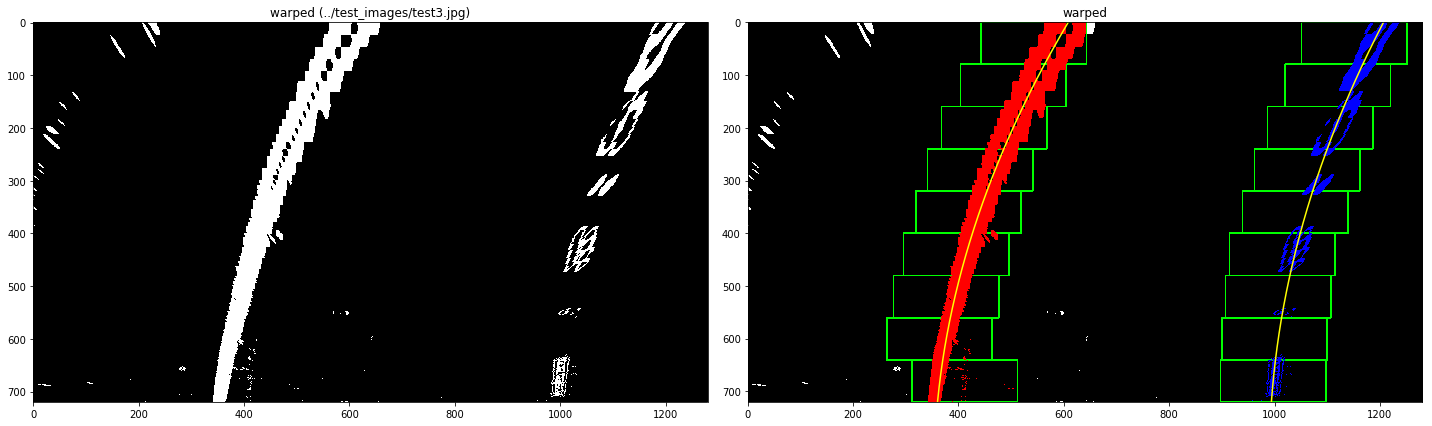

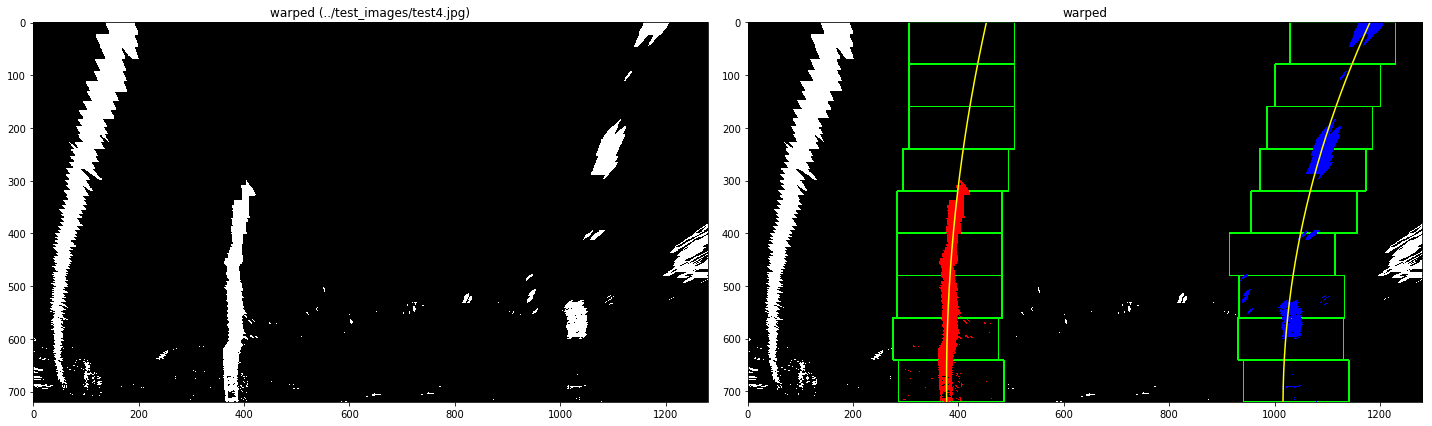

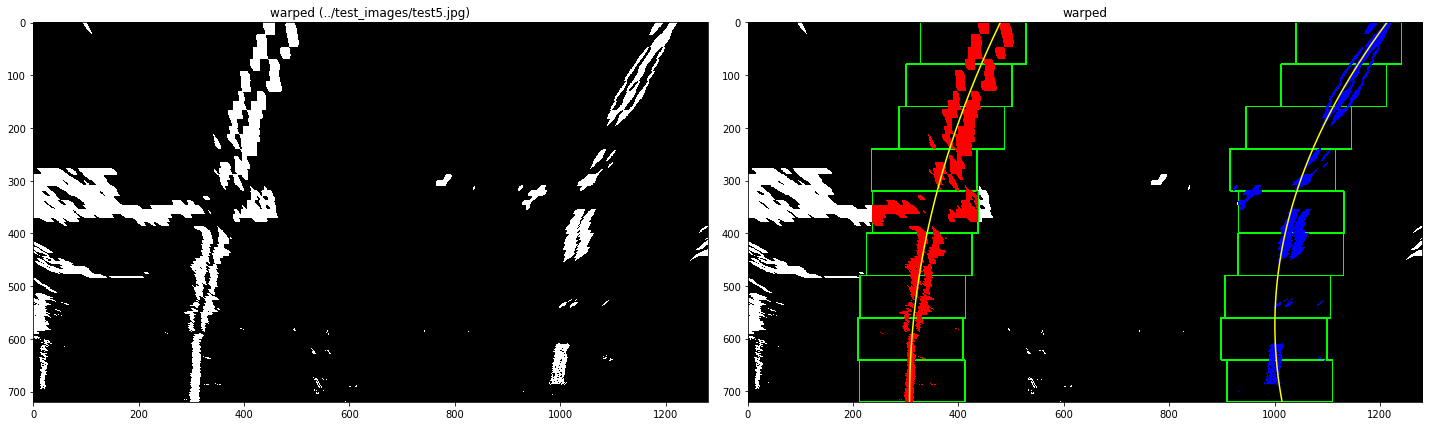

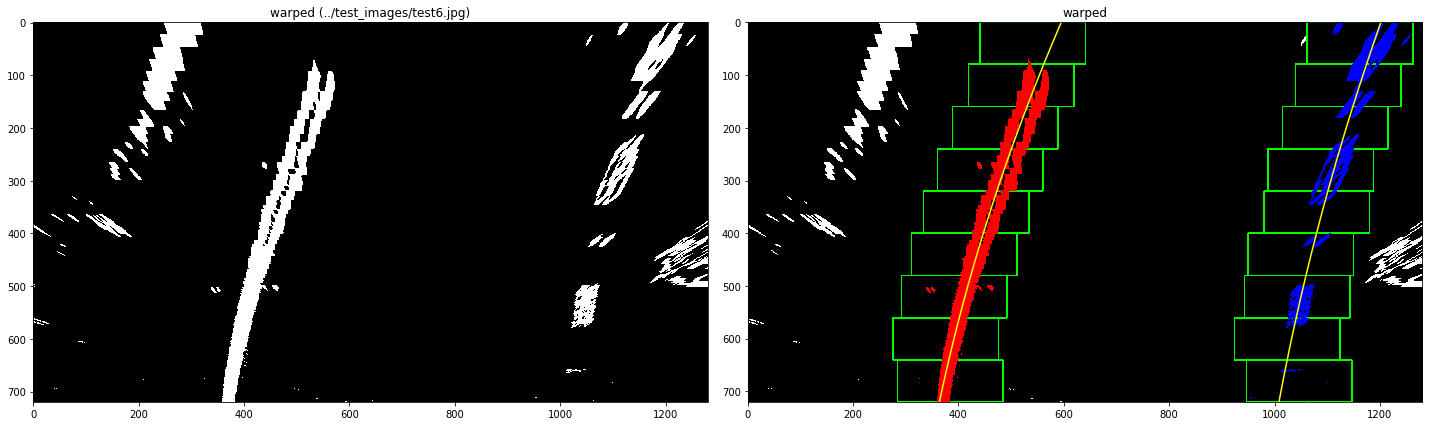

In [26]:
images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)

    hls = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)
    s = hls[:, :, 2]
    s_binary = thresh_filter(s, (170, 255))

    gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    sxbinary = abs_sobel_thresh(gray, 'x', 20, 100)

    #color_binary = np.dstack(( np.zeros_like(s_binary), sxbinary*200, s_binary*200))
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

    warped = cv2.warpPerspective(combined_binary, M, (combined_binary.shape[1], combined_binary.shape[0]), flags=cv2.INTER_LINEAR)

    
    histogram = np.sum(warped[warped.shape[0]//2:,:], axis=0)
#     plt.plot(histogram)    
    out_img = np.dstack((warped, warped, warped))*255

    midpoint = np.int(histogram.shape[0]/2)
    left_base = np.argmax(histogram[:midpoint])
    right_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    
    window_height = np.int(warped.shape[0]/nwindows)
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = left_base
    rightx_current = right_base
    
    margin = 100
    
    minpix = 50
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = warped.shape[0] - (window+1)*window_height
        win_y_high = warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img, (win_xleft_low, win_y_low), (win_xleft_high, win_y_high), (0, 255, 0), 2)
        cv2.rectangle(out_img, (win_xright_low, win_y_low), (win_xright_high, win_y_high), (0, 255, 0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    
    fig = plt.figure(figsize=(20, 12))

    plt.subplot(121)
    plt.imshow(warped, cmap='gray')
    plt.title('warped ('+fname+')')

    plt.subplot(122)
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
#     plt.imshow(warped, cmap='gray')
    plt.title('warped')


#     plt.axis('off')
    fig.tight_layout()
    plt.show()

In [52]:
warped[1][256]

1

In [50]:
warped.nonzero()[0][100]

1

In [51]:
warped.nonzero()[1][100]

256

In [8]:
# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(channel, sobel_kernel=3, mag_thresh_min=0, mag_thresh_max=255):
    # Convert to grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh_min) & (gradmag <= mag_thresh_max)] = 1

    # Return the binary image
    return binary_output

In [9]:
# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(channel, sobel_kernel=3, dir_thresh_min=0, dir_thresh_max=np.pi/2):
    # Grayscale
#     gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= dir_thresh_min) & (absgraddir <= dir_thresh_max)] = 1

    # Return the binary image
    return binary_output

In [10]:
fig=plt.figure(figsize=(24, 12))
plt.subplot(121)
plt.imshow(img)
plt.subplot(122)
plt.imshow(channel, cmap='gray')
fig.tight_layout()
plt.show()

NameError: name 'channel' is not defined

In [ ]:
def abs_sobel_x_y_mag_dir(channel, sobel_kernel=3,
           abs_sobel_x_thresh_min=30, abs_sobel_x_thresh_max=150,
           abs_sobel_y_thresh_min=30, abs_sobel_y_thresh_max=150,
           mag_thresh_min=20, mag_thresh_max=255,
           dir_threshold_min=0.6, dir_threshold_max=1.3):
    # Choose a Sobel kernel size
    ksize = sobel_kernel # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(channel, orient='x', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_x_thresh_min, abs_sobel_thresh_max=abs_sobel_x_thresh_max)
    grady = abs_sobel_thresh(channel, orient='y', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_y_thresh_min, abs_sobel_thresh_max=abs_sobel_y_thresh_max)
    mag_binary = mag_thresh(channel, sobel_kernel=ksize, mag_thresh_min=mag_thresh_min, mag_thresh_max=mag_thresh_max)
    dir_binary = dir_threshold(channel, sobel_kernel=ksize, dir_thresh_min=dir_threshold_min, dir_thresh_max=dir_threshold_max)
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1

    return combined
    
def update(sobel_kernel=3, 
           abs_sobel_x_thresh_min=30, abs_sobel_x_thresh_max=100,
           abs_sobel_y_thresh_min=30, abs_sobel_y_thresh_max=100,
           mag_thresh_min=30, mag_thresh_max=100,
           dir_threshold_min=0.9, dir_threshold_max=1.3):
    # Choose a Sobel kernel size
    ksize = sobel_kernel # Choose a larger odd number to smooth gradient measurements

    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(channel, orient='x', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_x_thresh_min, abs_sobel_thresh_max=abs_sobel_x_thresh_max)
    grady = abs_sobel_thresh(channel, orient='y', sobel_kernel=ksize, abs_sobel_thresh_min=abs_sobel_y_thresh_min, abs_sobel_thresh_max=abs_sobel_y_thresh_max)
    mag_binary = mag_thresh(channel, sobel_kernel=ksize, mag_thresh_min=mag_thresh_min, mag_thresh_max=mag_thresh_max)
    dir_binary = dir_threshold(channel, sobel_kernel=ksize, dir_thresh_min=dir_threshold_min, dir_thresh_max=dir_threshold_max)

    combined_1 = np.zeros_like(dir_binary)

    combined_1[((gradx == 1) & (grady == 1))] = 1
    
    combined_2 = np.zeros_like(dir_binary)
    combined_2[((mag_binary == 1) & (dir_binary == 1))] = 1

    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    fig = plt.figure(figsize=(20, 12))
    plt.subplot(131)
    plt.imshow(gradx, cmap='gray')
    plt.title('gradx')
    plt.axis('off')
    plt.subplot(132)
    plt.imshow(grady, cmap='gray')
    plt.title('grady')
    plt.axis('off')
    plt.subplot(133)
    plt.imshow(mag_binary, cmap='gray')
    plt.title('mag')
    plt.axis('off')
    fig.tight_layout()
    plt.show()

    fig=plt.figure(figsize=(20, 12))
    plt.subplot(121)
    plt.imshow(combined_1, cmap='gray')
    plt.title('gradx & grady')
    plt.axis('off')
    plt.subplot(122)
    plt.imshow(combined_2, cmap='gray')
    plt.title('dir')
    plt.axis('off')
    fig.tight_layout()
    plt.show()    

    fig = plt.figure(figsize=(20, 12))
    plt.imshow(combined, cmap='gray')
    plt.title('grad & mag')
    plt.axis('off')
    fig.tight_layout()
    plt.show()    
    

interact(update, sobel_kernel=(3, 19),abs_sobel_x_thresh_min=(0, 255), abs_sobel_x_thresh_max=(0, 255),
                 abs_sobel_y_thresh_min=(0, 255), abs_sobel_y_thresh_max=(0, 255),
                 mag_thresh_min=(0,255), mag_thresh_max=(0,255),
                 dir_threshold_min=(0, np.pi/2), dir_threshold_max=(0, np.pi/2))

In [ ]:
# mid = 1280/2
# t1, b1 = 450, 700
# t_tw = 90
# t_bw = 820
# t2, b2 = 10, 720
# tw = 400

# src = np.float32([[mid-t_tw, t1], [mid+t_tw, t1], [mid-t_bw, b1], [mid+t_bw, b1]])
# dst = np.float32([[mid-tw, t2], [mid+tw, t2], [mid-tw, b2], [mid+tw, b2]])

M = cv2.getPerspectiveTransform(src, dst)

images = glob.glob('../test_images/*.jpg')
for fname in images:
    img = mpimg.imread(fname)

    undist = cv2.undistort(img, mtx, dist, None, mtx)
    
    S = cv2.cvtColor(undist, cv2.COLOR_RGB2HLS)[:, :, 2]

    thresh = (130, 255)
    gray = np.zeros_like(S)
    gray[(S > thresh[0]) & (S <= thresh[1])] = 1
    
    filtered = abs_sobel_x_y_mag_dir(gray)

    warped = cv2.warpPerspective(filtered, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
    
    plt.figure(figsize=(16, 12))
    plt.subplot(121)
    plt.imshow(filtered, cmap='gray')
    
#     plt.plot(640, 420, 'o', mew=1)
    
#     plt.plot(mid-t_tw, t1, '^', mew=2)
#     plt.plot(mid+t_tw, t1, 'v', mew=2)
#     plt.plot(mid-t_bw, b1, 'x', mew=2)
#     plt.plot(mid+t_bw, b1, 's', mew=2)

#     plt.plot(mid-tw, t2, '^', mew=4)
#     plt.plot(mid+tw, t2, 'v', mew=4)
#     plt.plot(mid-tw, b2, 'x', mew=4)
#     plt.plot(mid+tw, b2, 's', mew=4)
    
    plt.title('Before('+fname+')')
    plt.subplot(122)
    plt.imshow(warped, cmap='gray')
    plt.title('Perspective transform')
    plt.axis('off')
    plt.show()